In [1]:
import scanpy as sc
import pertpy as pt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import distance, linkage, dendrogram
from seaborn import clustermap
import seaborn as sns
import matplotlib.pyplot as plt
import episcanpy as epi
from scipy import stats
import edistance as ed
from utils import equal_subsampling

#import etest

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

In [2]:
save_dir = "output/metric-comp-norman/"

In [7]:
def process_rna_adata(adata):
    adata.layers['counts'] = adata.X.copy()

    # basic qc and pp
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.normalize_per_cell(adata)
    sc.pp.filter_genes(adata, min_cells=50)
    #sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.log1p(adata)

    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)

    adata.uns['processed'] = True
    return(adata)

In [8]:
adata = sc.read_h5ad("/n/groups/marks/projects/scperturb/datasets/NormanWeissman2019_filtered/NormanWeissman2019_filtered.h5ad")

In [9]:
adata

AnnData object with n_obs × n_vars = 111445 × 33694
    obs: 'guide_id', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'perturbation', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo'
    var: 'ensemble_id', 'ncounts', 'ncells'

In [10]:
adata = process_rna_adata(adata)

In [11]:
adata = equal_subsampling(adata, obs_key = "perturbation", N_min = 200) 

In [13]:
adata

AnnData object with n_obs × n_vars = 39200 × 17414
    obs: 'guide_id', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'perturbation', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'n_counts'
    var: 'ensemble_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'processed'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [14]:
dists = {}
dists['mmd'] = pt.tools.Distance(metric='mmd')
dists['pseudobulk'] = pt.tools.Distance(metric='pseudobulk')
dists['wasserstein'] =  pt.tools.Distance(metric='wasserstein')


In [15]:
dist_dfs = {}
for key in dists:
    dist_dfs[key] = dists[key].pairwise(adata, groupby='perturbation')

Output()

Output()

Output()

In [18]:
dist_dfs['edist']=ed.edist(adata, "perturbation", flavor=1, dist='euclidean')

100%|█████████████████████████████████████████| 196/196 [01:22<00:00,  2.36it/s]


In [19]:
adata.write(save_dir+"processed_subset.h5ad")
dist_dfs['mmd'].to_csv(save_dir+"mmd.csv")
dist_dfs['pseudobulk'].to_csv(save_dir+"pseudobulk.csv")
dist_dfs['wasserstein'].to_csv(save_dir+"wasserstein.csv")
dist_dfs['edist'].to_csv(save_dir+"edist.csv")


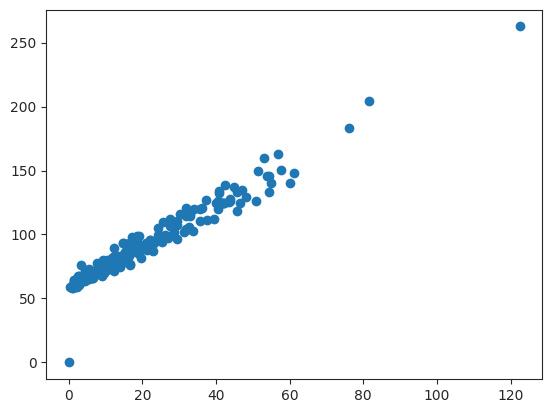

In [20]:
plt.scatter(dist_dfs['mmd']['control'],dist_dfs['wasserstein']['control'])

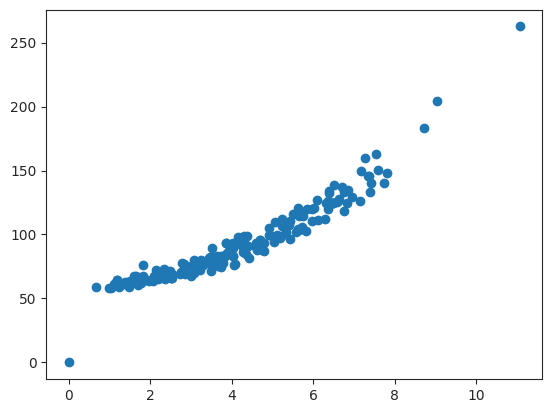

In [21]:
plt.scatter(dist_dfs['pseudobulk']['control'],dist_dfs['wasserstein']['control'])

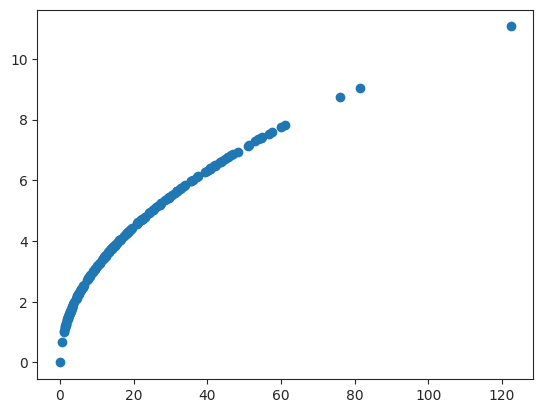

In [22]:
plt.scatter(dist_dfs['mmd']['control'],dist_dfs['pseudobulk']['control'])

In [23]:
#dist_dfs = {}
#dist_dfs['mmd'] = pd.read_csv("output/metric-comp-papalexi/mmd.csv", index_col=0)
#dist_dfs['pseudobulk'] = pd.read_csv("output/metric-comp-papalexi/pseudobulk.csv", index_col=0)
#dist_dfs['wasserstein'] = pd.read_csv("output/metric-comp-papalexi/wasserstein.csv",index_col=0)
#adata = sc.read_h5ad("output/metric-comp-papalexi/papalexi_processed_subset.h5ad")

In [24]:
magnitudes = pd.concat([dist_dfs[key]['control'] for key in dist_dfs], axis=1, keys =[key for key in dist_dfs] )

array([[<AxesSubplot: xlabel='mmd', ylabel='mmd'>,
        <AxesSubplot: xlabel='pseudobulk', ylabel='mmd'>,
        <AxesSubplot: xlabel='wasserstein', ylabel='mmd'>,
        <AxesSubplot: xlabel='edist', ylabel='mmd'>],
       [<AxesSubplot: xlabel='mmd', ylabel='pseudobulk'>,
        <AxesSubplot: xlabel='pseudobulk', ylabel='pseudobulk'>,
        <AxesSubplot: xlabel='wasserstein', ylabel='pseudobulk'>,
        <AxesSubplot: xlabel='edist', ylabel='pseudobulk'>],
       [<AxesSubplot: xlabel='mmd', ylabel='wasserstein'>,
        <AxesSubplot: xlabel='pseudobulk', ylabel='wasserstein'>,
        <AxesSubplot: xlabel='wasserstein', ylabel='wasserstein'>,
        <AxesSubplot: xlabel='edist', ylabel='wasserstein'>],
       [<AxesSubplot: xlabel='mmd', ylabel='edist'>,
        <AxesSubplot: xlabel='pseudobulk', ylabel='edist'>,
        <AxesSubplot: xlabel='wasserstein', ylabel='edist'>,
        <AxesSubplot: xlabel='edist', ylabel='edist'>]], dtype=object)

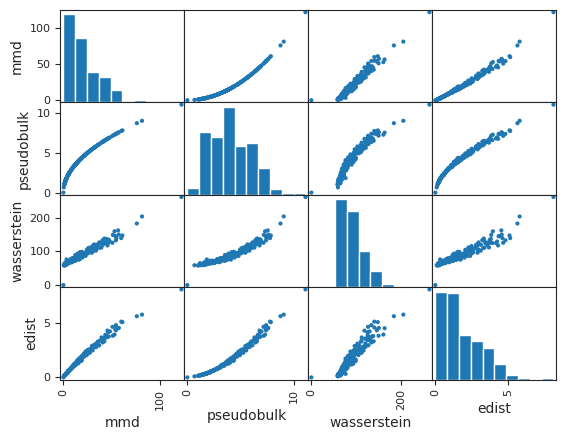

In [25]:
pd.plotting.scatter_matrix(magnitudes, alpha = 1)

In [26]:
# Min-Max Normalization
df = magnitudes
df_norm = (df-df.min())/(df.max()-df.min())
#df_norm = pd.concat((df_norm), 1)

array([[<AxesSubplot: xlabel='mmd', ylabel='mmd'>,
        <AxesSubplot: xlabel='pseudobulk', ylabel='mmd'>,
        <AxesSubplot: xlabel='wasserstein', ylabel='mmd'>,
        <AxesSubplot: xlabel='edist', ylabel='mmd'>],
       [<AxesSubplot: xlabel='mmd', ylabel='pseudobulk'>,
        <AxesSubplot: xlabel='pseudobulk', ylabel='pseudobulk'>,
        <AxesSubplot: xlabel='wasserstein', ylabel='pseudobulk'>,
        <AxesSubplot: xlabel='edist', ylabel='pseudobulk'>],
       [<AxesSubplot: xlabel='mmd', ylabel='wasserstein'>,
        <AxesSubplot: xlabel='pseudobulk', ylabel='wasserstein'>,
        <AxesSubplot: xlabel='wasserstein', ylabel='wasserstein'>,
        <AxesSubplot: xlabel='edist', ylabel='wasserstein'>],
       [<AxesSubplot: xlabel='mmd', ylabel='edist'>,
        <AxesSubplot: xlabel='pseudobulk', ylabel='edist'>,
        <AxesSubplot: xlabel='wasserstein', ylabel='edist'>,
        <AxesSubplot: xlabel='edist', ylabel='edist'>]], dtype=object)

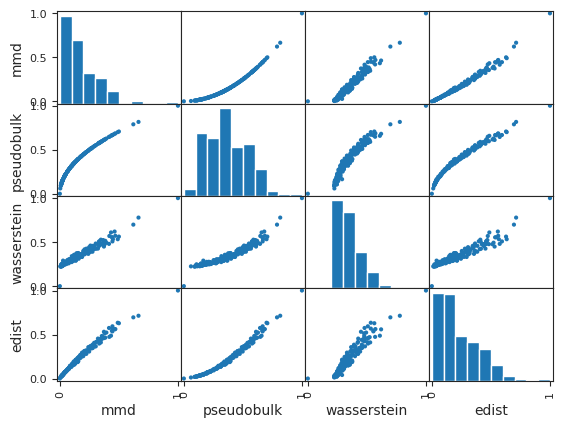

In [27]:
pd.plotting.scatter_matrix(df_norm, alpha = 1)

In [28]:
df_norm['perturbation']=df_norm.index

In [29]:
pl_df = pd.melt(df_norm, id_vars= "perturbation")

In [30]:
pl_df

,perturbation,variable,value
0,control,mmd,0.000000
1,KLF1,mmd,0.135354
2,BAK1,mmd,0.008716
3,CEBPE,mmd,0.419100
4,CEBPE_RUNX1T1,mmd,0.151622
...,...,...,...
779,POU3F2_CBFA2T3,edist,0.311734
780,CITED1,edist,0.186854
781,FOXO4,edist,0.233783
782,CEBPB_OSR2,edist,0.486734


In [31]:
pl_df.columns = ['perturbation','metric','distance']

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

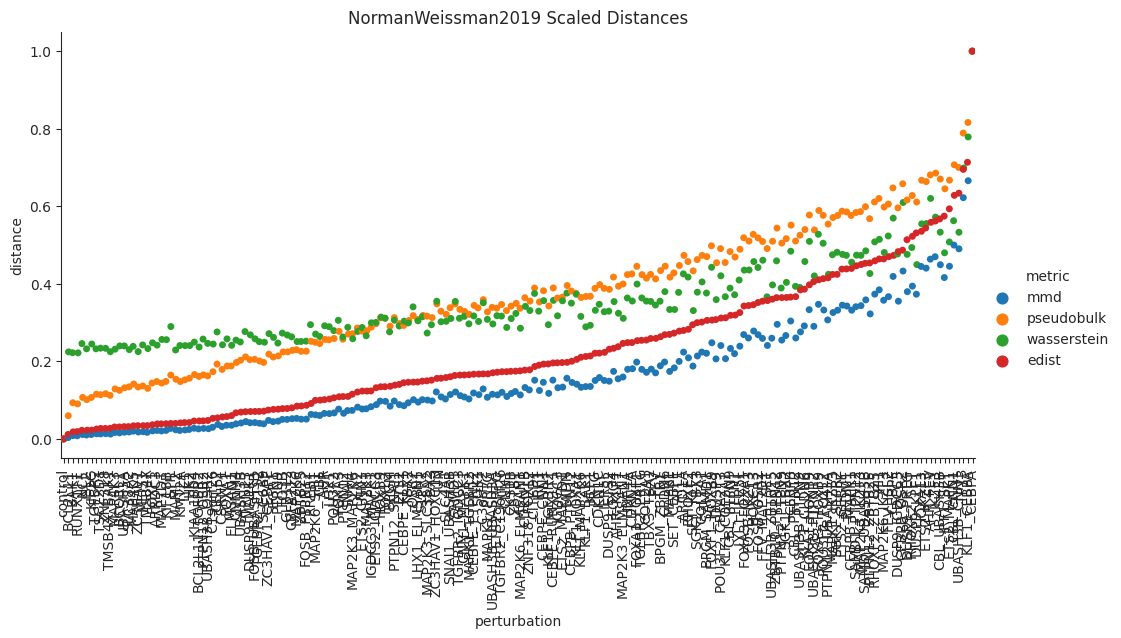

In [32]:
# stefan ideas for plotting multiple bars 

g2 = sns.catplot(data = pl_df, x = 'perturbation', y = 'distance', hue = 'metric', order =df_norm.sort_values('edist')['perturbation'] ,
                aspect=2)
#g2.set(xticklabels=[])  
g2.set(title="NormanWeissman2019 Scaled Distances")
plt.xticks(rotation=90)

 #groupby(hue).reset_index()
    #df.stack().reset_index()

Text(0.5, 1.0, 'NormanWeissman')

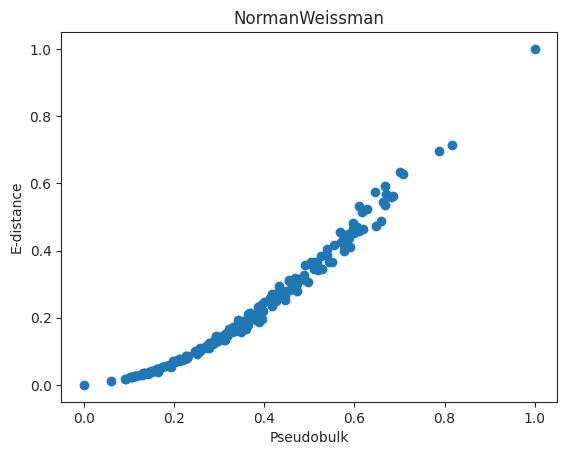

In [34]:
plt.scatter(df_norm['pseudobulk'],df_norm['edist'])
plt.xlabel("Pseudobulk")
plt.ylabel("E-distance")
plt.title("NormanWeissman")

In [35]:
(df_norm['pseudobulk'] - df_norm['edist']).sort_values()

perturbation
control           0.000000
CEBPA             0.000000
BCL2L11           0.048314
UBASH3B_CNN1      0.066353
IRF1_SET          0.070531
                    ...   
ZC3HAV1_HOXC13    0.192154
CEBPE_RUNX1T1     0.193351
ARID1A            0.193506
MIDN              0.197975
CITED1            0.202354
Length: 196, dtype: float64

In [36]:
magnitudes['perturbation']= magnitudes.index

In [37]:
magma = pd.melt(magnitudes, id_vars= "perturbation")

In [38]:
magma

,perturbation,variable,value
0,control,mmd,0.000000
1,KLF1,mmd,16.571627
2,BAK1,mmd,1.067106
3,CEBPE,mmd,51.311302
4,CEBPE_RUNX1T1,mmd,18.563332
...,...,...,...
779,POU3F2_CBFA2T3,edist,2.526808
780,CITED1,edist,1.514571
781,FOXO4,edist,1.894964
782,CEBPB_OSR2,edist,3.945298


In [39]:
magma.columns = ['perturbation','metric','distance']

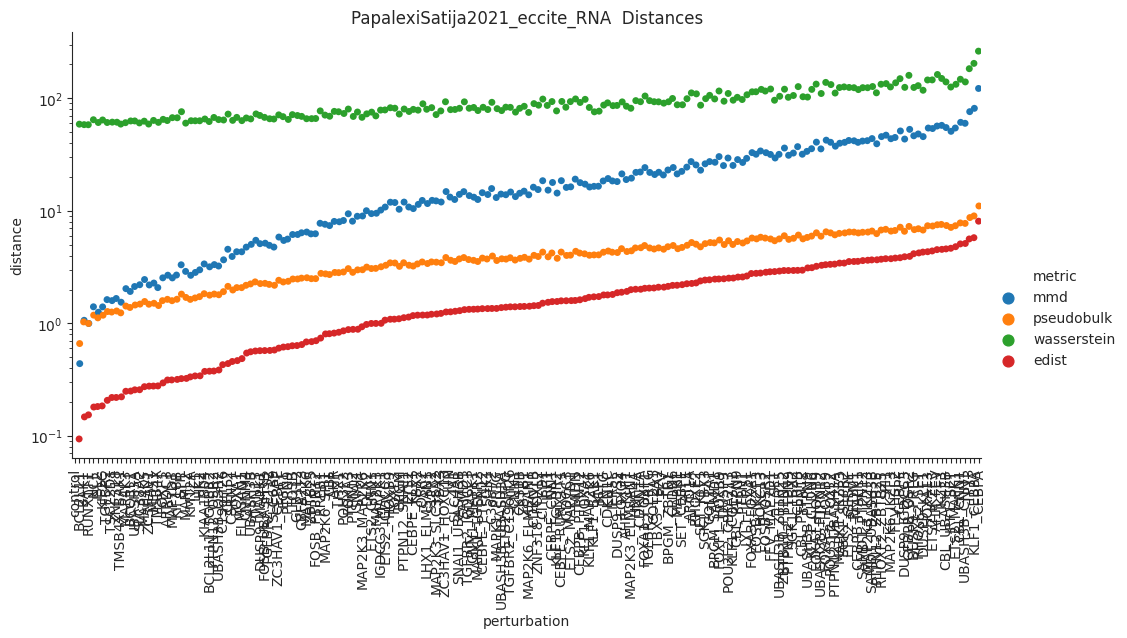

In [41]:

g2 = sns.catplot(data = magma, x = 'perturbation', y = 'distance', hue = 'metric', order =df_norm.sort_values('edist')['perturbation'] ,
                aspect=2)
#g2.set(xticklabels=[])  
g2.set(title="NormanWeissman  Distances")
#g2.set_yscale("log")
plt.xticks(rotation=90)
plt.yscale("log")

In [42]:
## next: add E-tests, choose shapes based on permutation testing results 

## also maybe some UMAPS for the ones which look kinda weird

In [43]:
sc.tl.umap(adata)

In [44]:
#sc.pl.umap(adata[adata.obs['perturbation'].isin(["control","IFNGR1g2", "STAT2g2","STAT2g1","NFKBIAg2"])], color = 'perturbation')

In [45]:
#sc.pl.umap(adata[adata.obs['perturbation'].isin(["control","IFNGR1g2", "STAT2g2","STAT2g1","NFKBIAg2"])], color = 'perturbation', 
#          palette="tab20")

In [3]:
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import pairwise_distances

def etest(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean',
          control='control', alpha=0.05, runs=1000, 
          correction_method='holm-sidak', correction_factor=False, 
          verbose=True):
    """Performs Monte Carlo permutation test with E-distance as test statistic.
    Tests for each group of cells defined in adata.obs[obs_key] if it is significantly
    different from control based on the E-distance in adata.obsm[obsm_key] space.
    Does multiple-testing correction using per default with Holm-Sidak.

    Arguments
    ---------
    adata: :class:`~anndata.AnnData`
        Annotated data matrix.
    obs_key: `str` in adata.obs.keys() (default: `perturbation`)
        Key in adata.obs specifying the groups to consider.
    obsm_key: `str` in adata.obsm (default: `adata.obsm['X_pca']`)
        Key for embedding coordinates to use.
    dist: `str` for any distance in scipy.spatial.distance (default: `sqeuclidean`)
        Distance metric to use in embedding space.
    control: `str` (default: `'control'`)
        Defines the control group in adata.obs[obs_key] to test against.
    alpha: `float` between `0` and `1` (default: `0.05`)
        significance cut-off for the test to annotate significance.
    runs: `int` (default: `100`)
        Number of iterations for the permutation test. This is basically the resolution of the E-test p-value.
        E.g. if you choose two iterations, then the p-value can only have 3 values `(0, .5, 1)`. Lower numbers will be much faster.
        We do not recommend going lower than `100` and suggest between `100` and `10000` iterations.
    correction_method: `None` or any valid method for statsmodels.stats.multitest.multipletests (default: `'holm-sidak'`)
        Method used for multiple-testing correction, since we are testing each group in `adata.obs[obs_key]`.
    correction_factor: `bool` (default: `False`)
        Whether make the estimator for sigma more unbiased (dividing by N-1 instead of N, similar to sample and population variance).
    verbose: `bool` (default: `True`)
        Whether to show a progress bar iterating over all groups.

    Returns
    -------
    tab: pandas.DataFrame
        E-test results for each group in adata.obs[obs_key] with columns
        - edist: E-distance to control
        - pvalue: E-test p-value if group is different from control
        - significant: If p-value < alpha
        - pvalue_adj: Multiple-testing corrected E-test p-value
        - significant_adj: If p-value_adj < alpha
    """

    groups = pd.unique(adata.obs[obs_key])
    
    # Compute pairwise distances selectively once
    # (we need pairwise distances within each group and between each group and control)
    # Note: this could be improved further, since we compute distances within control multiple times here. Speedup likely minimal though.
    pwds = {}
    for group in groups:
        x = adata[adata.obs[obs_key].isin([group, control])].obsm[obsm_key].copy()
        pwd = pairwise_distances(x,x, metric=dist)
        pwds[group] = pwd

    # Approximate sampling from null distribution (equal distributions)
    res = []
    fct = tqdm if verbose else lambda x: x
    for i in fct(range(runs)):
        # per perturbation, shuffle with control and compute e-distance
        df = pd.DataFrame(index=groups, columns=['edist'], dtype=float)
        for group in groups:
            if group==control:
                df.loc[group] = [0]
                continue
            # shuffle the labels
            labels = adata.obs[obs_key].values[adata.obs[obs_key].isin([group, control])]
            shuffled_labels = np.random.permutation(labels)
            
            # use precomputed pairwise distances
            sc_pwd = pwds[group]  # precomputed pairwise distances between single cells
            idx = shuffled_labels==group
            
            # Note that this is wrong: sc_pwd[idx, ~idx] but this is correct: sc_pwd[idx, :][:, ~idx]
            # The first produces a vector, the second a matrix (we need the matrix)
            delta = np.mean(sc_pwd[idx, :][:, ~idx])
            sigma = np.mean(sc_pwd[idx, :][:, idx])
            sigma_c = np.mean(sc_pwd[~idx, :][:, ~idx])
            
            edistance = 2 * delta - sigma - sigma_c

            df.loc[group] = edistance
        res.append(df.sort_index())

    # "Sampling" from original distribution without shuffling (hypothesis)
    df_old = ed.edist(adata, obs_key, obsm_key=obsm_key, dist=dist, verbose=False).loc[control]
    df_old.columns = ['edist']
    
    # the following is faster than the above and produces the same result
    original = []
    for group in groups:
        if group==control:
            original.append(0)
            continue
        # shuffle the labels
        labels = adata.obs[obs_key].values[adata.obs[obs_key].isin([group, control])]
        
        # use precomputed pairwise distances
        sc_pwd = pwds[group]  # precomputed pairwise distances between single cells
        idx = labels==group
        
        # Note that this is wrong: sc_pwd[idx, ~idx] but this is correct: sc_pwd[idx, :][:, ~idx]
        # The first produces a vector, the second a matrix (we need the matrix)
        delta = np.mean(sc_pwd[idx, :][:, ~idx])
        sigma = np.mean(sc_pwd[idx, :][:, idx])
        sigma_c = np.mean(sc_pwd[~idx, :][:, ~idx])
        
        edistance = 2 * delta - sigma - sigma_c
        original.append(edistance)
    df = pd.DataFrame(original, index=groups, columns=['edist'])
    df = df.sort_index()

    # Evaluate test (hypothesis vs null hypothesis)
    # count times shuffling resulted in larger e-distance
    results = np.array(pd.concat([r['edist'] - df['edist'] for r in res], axis=1) > 0, dtype=int)
    n_failures = pd.Series(np.clip(np.sum(results, axis=1), 1, np.inf), index=df.index)
    pvalues = n_failures / runs

    # Apply multiple testing correction
    significant_adj, pvalue_adj, _, _ = multipletests(pvalues.values, alpha=alpha, method=correction_method)

    # Aggregate results
    tab = pd.DataFrame({'edist': df['edist'], 'pvalue': pvalues, 
                        'significant': pvalues < alpha, 'pvalue_adj': pvalue_adj, 
                        'significant_adj': significant_adj}, index=df.index)
    return tab

In [4]:
perts_sig = {}

In [6]:
adata = sc.read_h5ad("/n/groups/marks/projects/scperturb/notebooks/output/metric-comp-norman/processed_subset.h5ad")

In [7]:
perts_sig['edist'] = etest(adata, obs_key='perturbation', obsm_key='X_pca', dist='euclidean',
          control='control', alpha=0.05, runs=1000, 
          correction_method='holm-sidak', correction_factor=True, 
          verbose=True)

100%|███████████████████████████████████████| 1000/1000 [04:38<00:00,  3.59it/s]


In [50]:
mmdtest = pt.tl.DistanceTest(metric = "mmd", n_perms = 1000)

In [51]:
perts_sig['mmd']=mmdtest(adata,groupby = "perturbation" , contrast = "control")

Output()

In [ ]:
wassertest = pt.tl.DistanceTest(metric = "wasserstein", n_perms = 1000)
perts_sig['wasserstein'] = wassertest(adata, groupby = 'perturbation', contrast = "control")

Output()

In [ ]:

g2 = sns.stripplot(data = magma, x = 'perturbation', y = 'distance', hue = 'metric', order =df_norm.sort_values('edist')['perturbation'] ,
                aspect=2)
#g2.set(xticklabels=[])  
g2.set(title="PapalexiSatija2021_eccite_RNA  Distances")
#g2.set_yscale("log")
plt.xticks(rotation=90)
plt.yscale("log")

In [ ]:
g2 = sns.catplot(data = magma, x = 'perturbation', y = 'distance', hue = 'metric', order =df_norm.sort_values('edist')['perturbation'] ,
                aspect=2, style = "significant",markers={True:'x', False: 'o'} )
#g2.set(xticklabels=[])  
g2.set(title="NormanWeissman  Distances")
#g2.set_yscale("log")
plt.xticks(rotation=90)
plt.yscale("log")

In [ ]:
perts_sig['wasserstein']['metric'] = "wasserstein"
perts_sig['edist']['metric'] = "edist"
perts_sig['mmd']['metric'] = "mmd"



In [ ]:
perts_sig['edist']=perts_sig['edist'].rename(columns={'edist':'distance'})

In [ ]:
sig_long = pd.concat([perts_sig['wasserstein'],perts_sig['edist'],perts_sig['mmd']])

In [ ]:
sig_long['perturbation']=sig_long.index

In [ ]:
sns.stripplot(data = sig_long, x = 'perturbation', y = 'distance', hue = 'metric', order =df_norm.sort_values('edist')['perturbation'] ,
                 )

In [ ]:
perts_sig['edist']['perturbation']=perts_sig['edist'].index

In [ ]:
ordr= df_norm.sort_values('edist')['perturbation']

In [ ]:
perts_sig['edist'] = perts_sig['edist'].loc[ordr]
perts_sig['mmd']=perts_sig['mmd'].loc[ordr]
perts_sig['wasserstein']=perts_sig['wasserstein'].loc[ordr]

In [ ]:
fig, ax = plt.subplots()

ax.scatter(perts_sig['edist']['perturbation'], perts_sig['edist']['distance'], label="edist",)
ax.scatter(perts_sig['edist']['perturbation'], perts_sig['mmd']['distance'], label="edist")
ax.scatter(perts_sig['edist']['perturbation'], perts_sig['wasserstein']['distance'], label="edist")

#ax.plot(activity, cat, label="cat")
ax.legend()
plt.xticks(rotation=90)
plt.yscale("log")

plt.show()


In [ ]:
#sns.set(rc={"figure.figsize":(12, 12)}) 
g3 = sns.scatterplot(data=sig_long.sort_values('distance'), x='perturbation', y='distance',
                     hue = 'metric',style="significant")

g3.set(title="PapalexiSatija2021_eccite_RNA  Distances")
#g2.set_yscale("log")
plt.xticks(rotation=90)
plt.yscale("log")


In [ ]:

for marker, d in perts_sig['edist'].groupby('significant'):
    plt.scatter(x=d['perturbation'], y=d['distance'], marker='o', label='-')
plt.legend()

In [ ]:
perts_sig['edist'].groupby('significant')

In [ ]:
perts_sig['mmd'].to_csv("output/metric-comp-norman/mmd_with_significance.csv")
perts_sig['wasserstein'].to_csv("output/metric-comp-norman/wasserstein_with_significance.csv")

In [8]:
perts_sig['edist'].to_csv("output/metric-comp-norman/edist_with_significance.csv")


In [10]:
etest_x = pt.tl.DistanceTest(metric = "edistance", n_perms = 1000)
etest_compare = etest_x(adata, groupby = 'perturbation', contrast = "control")

Output()

In [11]:
etest_compare

,distance,pvalue,significant,pvalue_adj,significant_adj
control,0.000000,1.000,False,1.000000,False
KLF1,1.725768,0.001,True,0.178068,False
BAK1,0.147199,0.001,True,0.178068,False
CEBPE,3.818111,0.001,True,0.178068,False
CEBPE_RUNX1T1,1.581046,0.001,True,0.178068,False
...,...,...,...,...,...
POU3F2_CBFA2T3,2.514174,0.001,True,0.178068,False
CITED1,1.506998,0.001,True,0.178068,False
FOXO4,1.885489,0.001,True,0.178068,False
CEBPB_OSR2,3.925571,0.001,True,0.178068,False


In [ ]:
perts_sig['e']